<a href="https://colab.research.google.com/github/bnelson05/Probing/blob/main/Probing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model and Data

# Pick a Pretrained Model
For example, distilbert-base-uncased-finetuned-sst-2-english or textattack/bert-base-uncased-SST-2.

Make sure you set it so it returns hidden states (e.g., output_hidden_states=True in the config/forward pass).

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.8 MB/s eta 0:00:00


In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.config.output_hidden_states = True
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


# Choose a Dataset
You can reuse an SST-2 dev/test split or a small subset of IMDB reviews—just keep it manageable (few hundred samples).

If you want to see domain differences, pick something that differs from the model’s training domain.

In [3]:
from datasets import load_dataset

imdb_ds = load_dataset("imdb")
train_subset = imdb_ds["train"].select(range(300))
test_subset = imdb_ds["test"].select(range(300))

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

# Extract Hidden States

# Forward Pass
Tokenize each sentence, call model(**inputs), and ensure you’re receiving outputs.hidden_states.

# Layer Representation
For each sample, you’ll get a tuple of hidden states (like one for each layer).

Decide how to get a single vector for the sentence:

*   If it’s BERT, you can grab the [CLS] token’s embedding.
*   Or average the token embeddings if there’s no [CLS].

Save those embeddings (e.g., shape = [num_samples, hidden_dim]) for each layer, plus the true label.

In [4]:
def get_hidden_states(subset):
  # ensures all layers including input embeddings are accounted for
  num_layers = model.config.num_hidden_layers + 1
  embeddings = [[] for _ in range(num_layers)]
  true_labels = []

  with torch.no_grad():
    for index in range(len(subset["text"])):
      sentence = subset["text"][index]
      label = subset["label"][index]
      # converts for model suitable input
      inputs = tokenizer(sentence, return_tensors="pt", truncation = True, max_length = 512)
      outputs = model(**inputs)
      hidden_states_received = outputs.hidden_states

      for i, layer in enumerate(hidden_states_received):
        # the CLS encodes information about the entire sentence
        # [batch, tokens, hidden_dim]
        cls = layer[0, 0, :].detach().cpu()
        embeddings[i].append(cls)

      true_labels.append(label)

  return embeddings, true_labels

# Training a Probe

# Logistic Regression
For each layer L, gather all embeddings into an (N, hidden_dim) array, with N = number of sentences.

Train a logistic regression (or SVM) to predict positive/negative.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class LogisticRegression(nn.Module):
  def __init__(self, input_dim):
    super(LogisticRegression, self).__init__()
    self.linear = nn.Linear(input_dim, 1)

  def forward(self, x):
    return self.linear(x).squeeze(-1)

def train_probe(hiddenStates, labels):
  layer_acc = {}
  trained_probes = {}
  num_layers = len(hiddenStates)

  for layer in range(num_layers):
    X_train = hiddenStates[layer]
    y_train = torch.tensor(labels, dtype = torch.float32)

    model = LogisticRegression(X_train.shape[1])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(50):
      optimizer.zero_grad()
      outputs = model(X_train)
      loss = criterion(outputs, y_train)
      loss.backward()
      optimizer.step()

    with torch.no_grad():
      predictions = (torch.sigmoid(model(X_train)) > 0.5).float()
      accuracy = (predictions == y_train).float().mean().item()
      layer_acc[layer] = accuracy
      trained_probes[layer] = model

    print(f"Train Layer {layer} -- Accuracy: {accuracy: .4f}")

  return trained_probes

def evaluate_probe(trainedProbes, hiddenStates, labels):
  layer_acc = {}
  num_layers = len(hiddenStates)

  for layer in range(num_layers):
    X_test = hiddenStates[layer]
    y_test = torch.tensor(labels, dtype = torch.float32)

    model = trainedProbes[layer]

    with torch.no_grad():
      predictions = (torch.sigmoid(model(X_test)) > 0.5).float()
      accuracy = (predictions == y_test).float().mean().item()
      layer_acc[layer] = accuracy

    print(f"Test Layer {layer} -- Accuracy: {accuracy: .4f}")

  layers = list(layer_acc.keys())
  accuracies = list(layer_acc.values())

  plt.figure(figsize = (10, 5))
  plt.plot(layers, accuracies, marker = 'o', linestyle = '-', label = "Test Accuracy")
  plt.xlabel("Layer")
  plt.ylabel("Accuracy")
  plt.title("Layer-wise Sentiment Prediction Accuracy (Test Set)")
  plt.grid()
  plt.show()


Train Layer 0 -- Accuracy:  1.0000
Train Layer 1 -- Accuracy:  1.0000
Train Layer 2 -- Accuracy:  1.0000
Train Layer 3 -- Accuracy:  1.0000
Train Layer 4 -- Accuracy:  1.0000
Train Layer 5 -- Accuracy:  1.0000
Train Layer 6 -- Accuracy:  1.0000
Test Layer 0 -- Accuracy:  1.0000
Test Layer 1 -- Accuracy:  1.0000
Test Layer 2 -- Accuracy:  1.0000
Test Layer 3 -- Accuracy:  1.0000
Test Layer 4 -- Accuracy:  1.0000
Test Layer 5 -- Accuracy:  1.0000
Test Layer 6 -- Accuracy:  1.0000


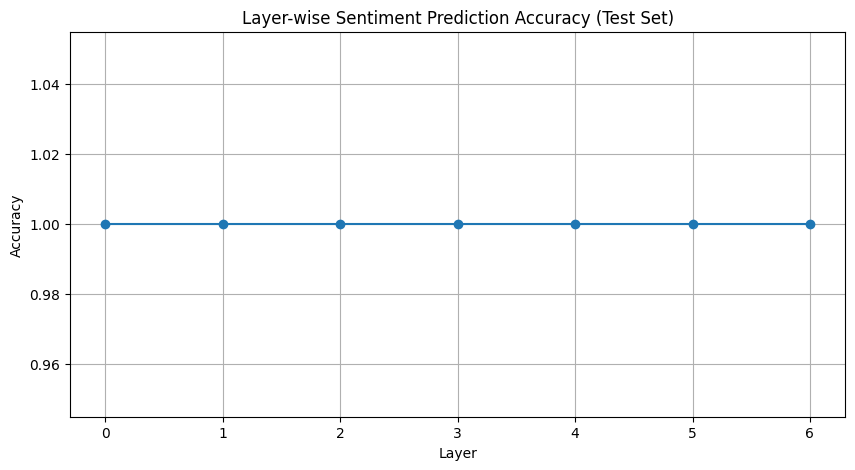

In [8]:
train_embeddings, train_labels = get_hidden_states(train_subset)
trainHiddenStates = [torch.stack(layer) for layer in train_embeddings]
trained_probes = train_probe(trainHiddenStates, train_labels)

test_embeddings, test_labels = get_hidden_states(test_subset)
testHiddenStates = [torch.stack(layer) for layer in test_embeddings]
evaluate_probe(trained_probes, testHiddenStates, test_labels)

# Analysis & Write-Up

# Plot / Table
Show the classification performance (accuracy/F1) vs. layer index. Which layer is best?

# Discussion
Link it to your attention findings: if you saw strong attention to sentiment words in the 8th layer, do you also see that layer’s embeddings produce top performance in the probe?

Any surprises? Maybe the final layer is best, or maybe a middle layer outperforms it.